# LAB 5 - submission

## Peter Cesarski
### peter.cesarski@nps.edu
### Polaris96@ieee.org¶¶

## I.  Environment

In [1]:
'''
NOTES
'''

#Need some assignment just to keep jupyter from rendering the string as output
#long quote strings are the standard *.py repr for c style long comments /* ... */
lab5 = 0

In [33]:
##Set up environment

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Ellipse
import matplotlib as mpl

import numpy as np

import pandas as pd

from scipy.stats import zscore as zscore

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline


## II.  Polaris Functions
The cell below is a more transparent way to ship my own functions than to tie in a custom library. I will do this until it gets too large. Then, I will bundle polaris.py with future submissions.


In [3]:
'''
THIS IS THE POLARIS LIBRARY.

FUNCTIONS CONAINED HERE WERE DEVELOPED IN EARLIER SUBMISSIONS AND CARRIED FORWARD FOR 
UTILITY.

I INTEND THIS TO BE A REAL WORLD TOOLKIT SO I CAN USE THESE TECHNIQUES IMEDIATELY IN
THE REAL WORLD.

THE FOLLOWING FUNCTIONS ARE CONTAINED:

    1.  OneOT:  PERFORMS ONE HOT ENCODING ON CATEGORIC COLUMNS.  FUNCTION DETERMINES
        WHETHER SIMPLE BINARY OR BINARY VECTORS ARE THE BEST CHOICE AND RETURNS THE 
        BEST SOLUTION.
        
        CALL WITH DATAFRAME, COL(ID), (PREFIX FOR OUTPUT COLS)
        
        RETURNS ONE HOT COL(S)
        
        DOES NOT DROP ORIGINIAL COLUMN
        
        
    2.  Train_val_test:  USES A DOUBLE CALL TO train_test_split TO CREATE train, val,
    test.
        CALL WITH DATAFRAME, %TRAIN, %VAL, %TEST, RND
        
        RETURNS TRAIN, VAL, TEST SETS
            *possibly should upgrade to return lists of refs like r does.  this would save 
             space in bad data
        
        train,val,test PERCENTAGES SHOULD BE WRITTEN AS DECIMALS.
        
        RND ALLOWS PASSING A SEED FOR REPEATABILITY
        
        ALL VALUES HAVE DEFAULTS (see code)
        
        
    3.  To_np_arrays:  RETURNS numPY ARRAYS OF THE PREDICTORS AND THE LABEL COLUMN.
    
        CALL WITH DATAFRAME, (COL_ID OF THE LABEL COLUMN)
        
        RETURNS numPY ARRAYS
        
        col_ID MUST BE INTEGER (.iloc) INDEX VALUE
        
        
    4.  Model_metrics:  RUNS A PREDICTION SET ON MODEL.  RETURNS STATISTICAL METRICS:
        
        'L2 POINT / C','accuracy','recall','precision','F1','AUC SCORE'  ARE RETURNED AS A 
        PANDAS SERIES (NOT A DATAFRAME)
        
        FUNCTION RETURNS A SERIES 'predictions' HOLDING PREDICTED VALUES
        AND A SERIES 'metrics' HOLDING THE METRICS
        
    
    5.  Partial_zscore(array,hold_columns,ddof=0):
        
        PARTIALLY ZSCORE THE ARRAY.  COLUMNS TO BE OMITTED FROM Z SCORING ARE IN [columns].  [columns]
        ARE CROPPED FROM THEIR INITIAL COLUMN INDICES AND APPENDED TO THE END POSITIONS AFTER THE 
        ARRAY IS ZSCORED.  CALL WITH numpy ARRAY not A PANDAS DataFrame.
        
        ddof is passed to scipy.stats.zscore
        
        
    6.  DF_Report(df):
    
        RETURN SOME STATISTICS ABOUT A DataFrame

    

'''




#####BEGIN LIBRARY CODE




##OK
#onehot wrapper with column name mods
def One_Hot(df,col_ref,descriptor):
    #this function is meant to work with numeric column reference
    #NOTE data columns as {0<col_ref<len}
    #
    #call with preselected categorical column/Series
    
    choices = len(df.iloc[:,col_ref].unique())
    if choices == 2:
        #in this case we only need one field
        one_hot = pd.get_dummies(df.iloc[:,col_ref], drop_first=True)
        one_hot.columns = [descriptor]
    else:
        one_hot = pd.get_dummies(df.iloc[:,col_ref])
        cols = [ descriptor + i for i in one_hot.columns ]
        one_hot.columns = cols
        
    return one_hot




##OK
#Create a 3 way data split
##I'm going to bet we will do more of this.  So functionalize:
##
def Train_val_test(df,trn=.5,val=.25,tst=.25,rnd=0):
    ##no need for **args.  This is basic
    #first split and then split the split.  Return training,valisdation,test
    
    #split the initial frame
    df_tr, df_alpha = train_test_split(df,test_size=(1-trn),random_state=rnd)
    
    #split the alpha frame into val and test
    df_vl,df_tst = train_test_split(df_alpha,test_size=(val/(val+tst)),random_state=rnd)
    
    
    #return training, validation, test
    return df_tr,df_vl,df_tst




##OK
##labels,y_A returned as floats.  Not sure where the casting happened
##works OK but might need to be tweaked in the future

def To_np_arrays(df,c_label):
    #return numpy arrays of predictors and label (result) column
    #c_label must be the column NUMERIC (.iloc) index not "index"
    
    #I'm going to exploit a neat feature of numpy: boolean indexing
    #It's faster than a comprehension (for big data) and 
    #I've always wanted to try it in something legit
    
    #transorm the whole frame
    alpha = df.to_numpy()
    
    #make a boolean mask.  Annoyingly, it must be T/F 1/0 doesn't seem to cut it.
    #I still need a comprehesion for the mask, but it's a small one
    mask = [ True if i != c_label else False for i in range(alpha.shape[1]) ]
    
    #use boolean indexing to parse the original array
    np_X = alpha[:,np.array(mask)]
    #use the formally supplied column number to separate the label column
    np_y = alpha[:,np.array(c_label)]
    
    
    #return 'df without [,clabel] as np', '[:c_label] as np'
    return np_X,np_y




def Model_metrics(stats,model,data,label):
    #Calculate the predictions, precision, and recall of the best validation model 
    #on the test set(data)
    
    #stats is a dict holding any other metrics to be passed into the Series

    preds_test = model.predict(data)
    
    accuracy = accuracy_score(label,preds_test)
    F1 = f1_score(label,preds_test)
    precision = precision_score(preds_test,label)
    recall = recall_score(preds_test,label)
    AUC = roc_auc_score(model.predict(data),label)
    
    ##I don't know why casting is required below, but it is...
    Sindex = list(stats.keys()) + ['accuracy','recall','precision','F1','AUC']
    Sdata = list(stats.values()) + [accuracy,recall,precision,F1,AUC]
    
    
    #also return the preds test as a Series for graphing, etc
    return pd.Series(preds_test,name='predictions'),pd.Series( Sdata,
                                     index=Sindex,name='metrics'
                                        )





def plot_ROC(predictions,labels):
    ##in the alpha state predictions is a Series and labels is a list
    ## at some point, I will decide which is the most appropriate dtype
    ##atm tending towards Series since the whole kaboodle needs pandas anyway.
    
    #Plot the ROC curve for the best validation model on the test set
    fpr, tpr, _ = roc_curve(predictions.tolist(),y_test)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    
    
    return 0






def Partial_zscore(array,hold_columns,ddof=0):
    #return an np.array with all data zscored except columns listed in hold_columns
    #hold_columns is a list of indices.
    #ddof is passed to scipy.stats.zscore
    '''
    from SO:
    https://stackoverflow.com/questions/24506227/how-to-slice-a-numpy-array-by-a-list-of-column-indices
    
    
    When using a slice such as arr[:, :5:2], no data is copied, and we get a view of the original array. 
    This implies that mutating the result of arr[:, :5:2] will affect arr itself. With fancy indexing 
    arr[:, [0, 3, 4]] is guaranteed to be a copy: this takes up more memory, and mutating this result will not 
    affect arr.

    I believe array masking uses fancy indexing and this may be why I've had the problems with masked arrays 
    in the last Lab

    '''
    
    #array_z =  
    
    #Split off an array of columns to be held
    no_Z = array[:, hold_columns]
    #delete the columns from array (axis=1 for operating 'horizontally' across columns)
    array = np.delete(array, hold_columns, axis=1)
    
    #Zscore with scipy
    array_Z = zscore(array,axis=0,ddof=ddof)
    ##axis 0 for operating 'vertically' down rows
    #  This gives a 'per column' zscore.  Looks weird but actually makes sense.


    #recombine the z-scored columns with the held column (0)
    array_Z = np.column_stack((array_Z,no_Z))
    
    #TESTING:
    #return no_Z,array,array_Z
    
    #finishing touches:
    
    #free memory
    del no_Z
    del array
    
    
    return array_Z 






def DF_Report(df):
    report = []
    report.append(df.shape)
    report.append(df.columns[:])
    report.append(df.dtypes)
    #report.append(df.head(5))
    
    return pd.Series(report,index=['shape','columns','dtypes'])










#####END LIBRARY CODE

### New work Functions
These are general purpose functions developed to be added to the library

In [4]:
'''
NEW FUNCTIONS

1.  THESE FUNCTIONS WERE DEVELOPED FOR THIS ASSIGNMENT OR REPACKAGED FROM EARLIER LAB CODE.

2.  ALL CODE IN THIS CELL IS FUNCTIONALIZED AND CALLABLE / TRANSFERRABLE.

'''






##OK
def strip_Series(df,col_ref):
    ##remove whitespace.
    #this function is meant to work with numeric column reference
    #NOTE data columns as {0<col_ref<len}
    stripped = [ i.strip() for i in df.iloc[:,col_ref] ]
    
    return pd.Series(stripped)






def rtn_indices_with(df,col_ref,flag):
    ##return a list of all occurrences of FLAG
    ##Today, flag will be '?'
    
    #create a boolean 'mask' array 
    dd = df.iloc[:,col_ref].str.contains(flag)
    #make a list of indices where the flag occurs
    indices = [ind for ind, ele in enumerate(dd) if ele == True]
    #boolean dataframe is an iterable object.  using iterate we cycle the array and test the mask
    #picking up the index value for a true hit
    
    
    return indices






def Munge(df):
    ##return a sanitized dataframe.
    ##cleaning actions:
    #       trim whitespace
    #       delete any records with indeterminate data
    #              1.  defined as '?'
    #       perform One Hot encoding on categorical data
    #              1.  vectorize data
    #              2.  concatenate vecor / One Hot columns
    #              3.  drop nonumeric categorical columns
    #              
    #we'll need to know the categorical columns so we can drop them later
    cat_col=[]

    for i in range(0,len(df.dtypes)):
        if df.dtypes[i]=='object':
            #first remove whitespace
            df.iloc[:,i].update(strip_Series(df,i))
            #test for bad data '?'
            bad_data = rtn_indices_with(df,i,'\?')
            #drop bad rows
            for corrupt in bad_data:
                df.drop([df.index[corrupt]],inplace=True)
            #create one_hot vectors
            one_hot = One_Hot(df,i,'OH_'+ str(df.columns[i]))
            #cocatenate One_Hot vectors or binary as appropriate
            df = pd.concat([df, one_hot], axis=1)
            #pick up plain name of column (just makes life easier when dropping)
            #memory jog:  axis=0 for rows, axis=1 for columns
            cat_col += [df.columns[i]]

    ##Because I'm driving everything by iteration, I don't want to drop columns
    ##inside the loop.  Doing so changes the dataframe Series set too early and
    ##messes up the data munging.

    ##so, NOW I will delete columns that have been One_Hotted
    df.drop(cat_col, axis=1,inplace=True)
    
    
    return df
                


# III. Lab Work

1.  Load **armada.csv** using pandas

In [5]:
#load dataframe from csv
df = pd.read_csv("armada.csv")

In [6]:
DF_Report(df)

shape                                                (28, 8)
columns    Index(['Battle', 'Year', 'Portuguese Ships', '...
dtypes     Battle                                        ...
dtype: object

2.  drop the **"Battle"** column

In [7]:
df.drop(columns='Battle',inplace=True)
DF_Report(df)

shape                                                (28, 7)
columns    Index(['Year', 'Portuguese Ships', 'Dutch Ship...
dtypes     Year                                          ...
dtype: object

3. Remove rows with missing data (denoted with ”?”).
4. Replace categorical data with either binary variables or one-hot vectors, as is appropriate.

In [8]:
df = Munge(df)
DF_Report(df)

shape                                                (27, 9)
columns    Index(['Year', 'Portuguese Ships', 'Dutch Ship...
dtypes     Year                                          ...
dtype: object

In [9]:
df.head()

Year  Portuguese Ships  Dutch Ships  English Ships  \
0  1601                 6            3              0   
1  1606                14           11              0   
2  1606                 6            9              0   
3  1606                 7            9              0   
4  1615                 6            0              4   

   Ratio of Portuguese Ships to Dutch/British Ships  OH_Spanish Involvement  \
0                                             2.000                       0   
1                                             1.273                       0   
2                                             0.667                       0   
3                                             0.778                       0   
4                                             1.500                       0   

   OH_Portuguese OutcomeDefeat  OH_Portuguese OutcomeDraw  \
0                            0                          1   
1                            0                          1   
2                            1                          0   
3                            0                          0   
4                            0                          1   

   OH_Portuguese OutcomeVictory  
0                             0  
1                             0  
2                             0  
3                             1  
4                             0

5. Z-score the all columns using the sample statistics.

In [10]:
df_Z = zscore(df.to_numpy(),ddof=0)
df_Z[:3,:]

array([[-1.54860671, -0.44222176, -0.44527566, -0.31295264,  0.88775361,
        -0.89442719, -0.70710678,  1.03774904, -0.47673129],
       [-1.26143377,  0.06051456, -0.08233399, -0.31295264,  0.09768671,
        -0.89442719, -0.70710678,  1.03774904, -0.47673129],
       [-1.26143377, -0.44222176, -0.17306941, -0.31295264, -0.5608835 ,
        -0.89442719,  1.41421356, -0.96362411, -0.47673129]])

6. Use PCA to transform the data into a 2-dimensional representation.

In [11]:
###NOTING The difference between this and the example code
##  I'm transforming the dataset FIRST per the lab instructions
##  The example models K Means first


##  question:   Are these processes commutative?


#Apply PCA to the input data array using two components
pca_2 = PCA(n_components=2)
df_Z_2_pca = pca_2.fit_transform(df_Z)
#df_Z_2_pca

7. Find the best k-means model for the PCA’d data using inertia and the ”elbow plot” method.

In [12]:
#Calculate the intertias for different values of k
inertias = []
ks = []
for i in range(10):
    k = i+1
    ks.append(k)
    print('K='+str(k))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_Z_2_pca)
    print('inertia='+str(kmeans.inertia_))
    inertias.append(kmeans.inertia_)

K=1
inertia=122.58627578840465
K=2
inertia=71.85502554703767
K=3
inertia=33.576510069151354
K=4
inertia=19.979228040079423
K=5
inertia=13.170211650701463
K=6
inertia=8.78457062540807
K=7
inertia=6.355967601558578
K=8
inertia=4.078106547424213
K=9
inertia=3.4085074942725737
K=10
inertia=2.601269505626824


Text(0, 0.5, 'Inertia')

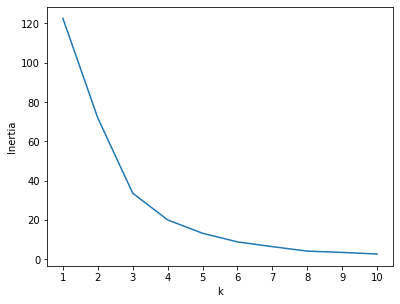

In [13]:
#Create an inertia elbow plot
xs = np.array(list(range(len(ks))))
fig = plt.figure()
ax = fig.add_axes([0.1,0.2,0.8,0.9])
ax.plot(xs,inertias)
ax.set_xticks(xs)
ax.set_xticklabels(ks)
ax.set_xlabel('k')
ax.set_ylabel('Inertia')

_I like **k=4** here.  In class, it seemed like the knee at **k=3** was chosen.  I feel like there's still sufficient di/dk at k=4 to warrant it's inclusion._

_However, when I tried it, the scatter plot didn't seem to correlate with best k from the elbow pot_

Using k=4 gave unreasonable centroids and made me feel there was a bit of overfitting.  opting for **k=3**

8. Plot Plot the PCA’d data and the means of the best k-means model.

In [19]:
#Apply PCA to the input data array using four components
kMeans_3 = KMeans(n_clusters=3)
kMeans_3.fit(df_Z_2_pca)

KMeans(n_clusters=3)

Text(0.5, 1.0, '2D PCA Plot with k-Means')

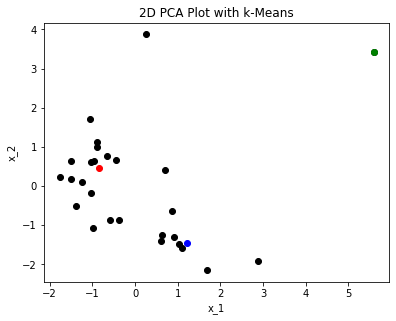

In [20]:
#Plot the PCA transformed input data and the corresponding centroids for k-means with k=4
fig = plt.figure()
ax = fig.add_axes([0.1,0.2,0.8,0.9])
ax.scatter(df_Z_2_pca[:,0],df_Z_2_pca[:,1],c='k')
colors = ['r','b','g','y']
for i in range(3):
    ax.scatter(kMeans_3.cluster_centers_[i,0],kMeans_3.cluster_centers_[i,1],c=colors[i])
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
plt.title('2D PCA Plot with k-Means')

_I almost feel like **k=2** would be the best model based on the scatter..._

9. Find the best Gaussian mixture model for the PCA’d data using BIC.

In [30]:
##Direct c/p from your example.  I wouldn't be able to make anything better ina reasonable timeframe...
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [26]:
df_Z_2_pca.shape

(27, 2)

In [27]:
#Calculate the intertias for different values of k
bics = []
ks = []
for i in range(27):
    k = i+1
    ks.append(k)
    print('K='+str(k))
    gmm = GaussianMixture(n_components=k)
    gmm.fit(df_Z_2_pca)
    bic = gmm.bic(df_Z_2_pca)
    print('bic='+str(bic))
    inertias.append(bic)

K=1
bic=213.80361745463262
K=2
bic=208.6726967026659
K=3
bic=176.54526737056713
K=4
bic=191.93039952121597
K=5
bic=173.39155896036266
K=6
bic=165.29123519214428
K=7
bic=167.8093702364514
K=8
bic=153.77337359847576
K=9
bic=139.41319315267535
K=10
bic=145.2403834928212
K=11
bic=134.23026636880113
K=12
bic=129.72067743807236
K=13
bic=117.64580448388173
K=14
bic=124.28200837953415
K=15
bic=101.7437358995902
K=16
bic=86.04645465945924
K=17
bic=76.49548807189524
K=18
bic=58.06180235247513
K=19
bic=50.941340815759816
K=20
bic=40.30431848737368
K=21
bic=50.82525450659057
K=22
bic=42.81631284788375
K=23
bic=44.590604590865894
K=24
bic=47.5470007934062
K=25
bic=51.4250462733836
K=26
bic=55.5477603360888
K=27
bic=61.81271764696476


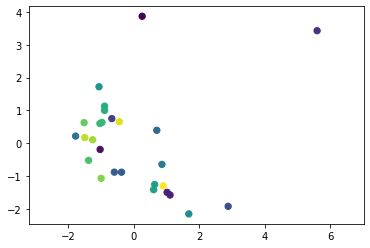

In [34]:
gmm = GaussianMixture(n_components=22)
plot_gmm(gmm,df_Z_2_pca)

_BIC was minized at k=22 per the iteration.  Not much density on the plot.  If I messed up I cannot see where, but I feel like there should be more 'pop' in the final plot_